# Package

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
def initialize_parameters(seed=7, num_agents=10000, m=3, penalty_margin=0.5):
    np.random.seed(seed)
    type_dist = np.random.dirichlet(np.random.uniform(1, 2, m))
    payments, penalties = generate_payments_and_penalties(type_dist, penalty_margin, m)
    return num_agents, m, type_dist, payments, penalties

In [3]:
def generate_payments_and_penalties(type_dist, penalty_margin, m):
    payments = np.zeros(m)
    cumulative = 0
    for i in range(m):
        cumulative += type_dist[i]
        payments[i] = 1 + cumulative / 2
    penalties = payments + penalty_margin
    return payments, penalties

In [4]:
def valuation_function(i, k, payments):
    if k == i:
        return payments[i]
    elif k > i:
        return max(payments[i] - 0.2 * (k - i), 0.0)
    else:
        return max(payments[i] - 0.4 * (i - k), 0.0)

#Principal utility computation

In [5]:
def principal_utility(type_dist, audit_vector, cost, equilibrium_strategy, num_agents, payments, penalties):
    utility = 0
    for idx in range(len(type_dist)):
        reported_type = equilibrium_strategy[idx]
        utility += type_dist[idx] * (
            valuation_function(idx, reported_type, payments)
            - payments[reported_type]
            + audit_vector[reported_type] * (penalties[reported_type] - cost)
        )
    return utility * num_agents

In [6]:
def determine_equilibrium_strategy(payments, penalties, audit_vector, epsilon):
    u_hat = np.max(payments - audit_vector * penalties)
    A_hat = np.where(payments - audit_vector * penalties >= u_hat - epsilon)[0]
    equilibrium_strategy = np.zeros(len(payments), int)
    for idx in range(len(payments)):
        truthful_util = payments[idx]
        equilibrium_strategy[idx] = idx if truthful_util >= u_hat - epsilon else np.min(A_hat)
    return equilibrium_strategy

In [7]:
#search for optimal non-adaptive utility considering epsilon perturbation on critical policies
def optimal_non_adaptive_policy(type_dist, payments, penalties, cost, m, num_agents, epsilon):
    best_utility = -np.inf
    optimal_audit_vector = np.zeros(m)
    # Iterate through critical policy indices
    for i in range(m - 1):
        for u in [payments[i] + epsilon, payments[i + 1] - epsilon]:
            audit_vector = np.zeros(m)
            # set audit probabilities as per critical policy definition
            for k in range(m):
                if k < i:
                    audit_vector[k] = 0  # explicitly zero for k < i
                else:
                    audit_vector[k] = np.clip((payments[k] - u) / penalties[k], 0, 1)
            # Explicit equilibrium strategy
            eq_strategy = determine_equilibrium_strategy(payments, penalties, audit_vector, epsilon)
            utility = principal_utility(type_dist, audit_vector, cost, eq_strategy, num_agents, payments, penalties)
            if utility > best_utility:
                best_utility = utility
                optimal_audit_vector = audit_vector.copy()
    return best_utility, optimal_audit_vector




In [8]:
# search for optimal adaptive utility without epsilon perturbation on critical policies
def optimal_adaptive_policy(type_dist, payments, penalties, cost, m, num_agents):
    epsilon = 0  # explicitly adaptive setting
    best_utility = -np.inf
    optimal_audit_vector = np.zeros(m)
    for i in range(m - 1):
        for u in [payments[i], payments[i + 1]]:
            audit_vector = np.zeros(m)
            # set audit probabilities correctly
            for k in range(m):
                if k < i:
                    audit_vector[k] = 0  #zero for k < i
                else:
                    audit_vector[k] = np.clip((payments[k] - u) / penalties[k], 0, 1)
            eq_strategy = determine_equilibrium_strategy(payments, penalties, audit_vector, epsilon)
            utility = principal_utility(type_dist, audit_vector, cost, eq_strategy, num_agents, payments, penalties)
            if utility > best_utility:
                best_utility = utility
                optimal_audit_vector = audit_vector.copy()
    return best_utility, optimal_audit_vector


In [9]:
def verify_assumptions(payments, penalties, cost, type_dist, audit_vector, epsilon=None):
    A1 = np.all(cost <= penalties)
    A2 = np.all(np.diff(payments) / payments[:-1] >= np.diff(penalties) / penalties[:-1])
    A3 = np.all(np.diff(payments) >= 0)
    A4 = np.all(penalties >= payments)
    A5 = np.isclose(np.sum(type_dist), 1)

    min_payment_diff = np.min(np.diff(payments))

    if epsilon is not None:
        A6 = (0 < epsilon < 0.5 * min_payment_diff)  # Explicitly correct A6
    else:
        A6 = True  # Explicitly adaptive case

    A7 = np.all((audit_vector >= 0) & (audit_vector <= 1))

    return A1, A2, A3, A4, A5, A6, A7

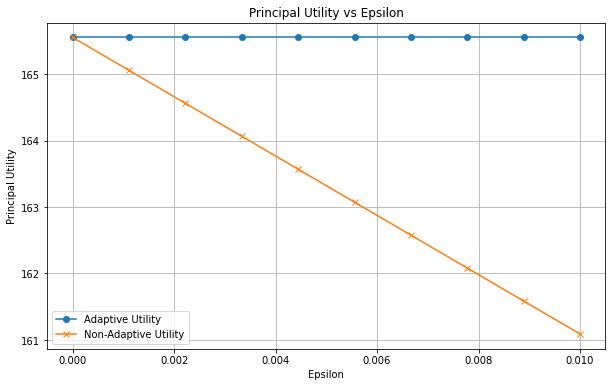

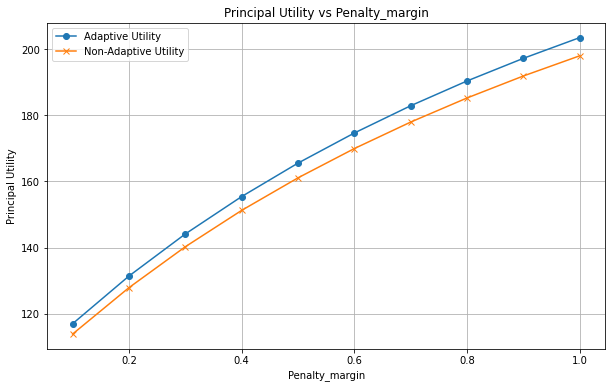

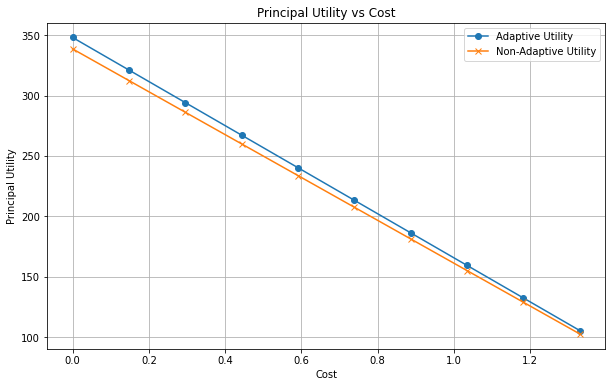

In [10]:
def run_simulation_varying_param(param_name, param_values, fixed_values):
    results_adaptive = []
    results_non_adaptive = []

    violation_reported = False

    for param in param_values:
        # Set parameters
        cost = fixed_values.get('cost', 1.0)
        epsilon = fixed_values.get('epsilon', 1e-6)
        penalty_margin = fixed_values.get('penalty_margin', 0.5)

        if param_name == 'cost':
            cost = param
        elif param_name == 'epsilon':
            epsilon = param
        elif param_name == 'penalty_margin':
            penalty_margin = param
        else:
            raise ValueError("Invalid parameter name.")

        # Initialize parameters
        num_agents, m, type_dist, payments, penalties = initialize_parameters(penalty_margin=penalty_margin)

        # Run adaptive and non-adaptive policies
        adaptive_utility, audit_vector_ad = optimal_adaptive_policy(type_dist, payments, penalties, cost, m, num_agents)
        non_adaptive_utility, audit_vector_na = optimal_non_adaptive_policy(type_dist, payments, penalties, cost, m, num_agents, epsilon)

        results_adaptive.append(adaptive_utility)
        results_non_adaptive.append(non_adaptive_utility)

        if not violation_reported:
            A1, A2, A3, A4, A5, A6, A7_na = verify_assumptions(payments, penalties, cost, type_dist, audit_vector_na, epsilon)
            _, _, _, _, _, _, A7_ad = verify_assumptions(payments, penalties, cost, type_dist, audit_vector_ad, epsilon=0)

            if not (A1 and A2 and A3 and A4 and A5 and A6 and A7_na):
                print(f"Warning: Non-adaptive assumptions violated at {param_name}={param}")
                violation_reported = True

            if not (A1 and A2 and A3 and A4 and A5 and A7_ad):
                print(f"Warning: Adaptive assumptions violated at {param_name}={param}")
                violation_reported = True

    plot_results(param_values, results_adaptive, results_non_adaptive, param_name)

# Plotting function
def plot_results(param_values, adaptive_utility, non_adaptive_utility, param_name):
    plt.figure(figsize=(10, 6))
    plt.plot(param_values, adaptive_utility, label='Adaptive Utility', marker='o')
    plt.plot(param_values, non_adaptive_utility, label='Non-Adaptive Utility', marker='x')
    plt.xlabel(param_name.capitalize())
    plt.ylabel('Principal Utility')
    plt.title(f'Principal Utility vs {param_name.capitalize()}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example execution
if __name__ == "__main__":
    # Example: vary epsilon
    epsilon_values = np.linspace(0, 0.01, 10)
    run_simulation_varying_param('epsilon', epsilon_values, {'cost': 1.0, 'penalty_margin': 0.5})

    # Example: vary penalty_margin
    penalty_values = np.linspace(0.1, 1.0, 10)
    run_simulation_varying_param('penalty_margin', penalty_values, {'cost': 1.0, 'epsilon': 1e-2})

    # Example: vary cost
    cost_values = np.linspace(0, 1.33, 10)
    run_simulation_varying_param('cost', cost_values, {'epsilon': 1e-2, 'penalty_margin': 0.5})


Non-Adaptive assumptions violated at m=25: (True, True, True, True, True, False, True)


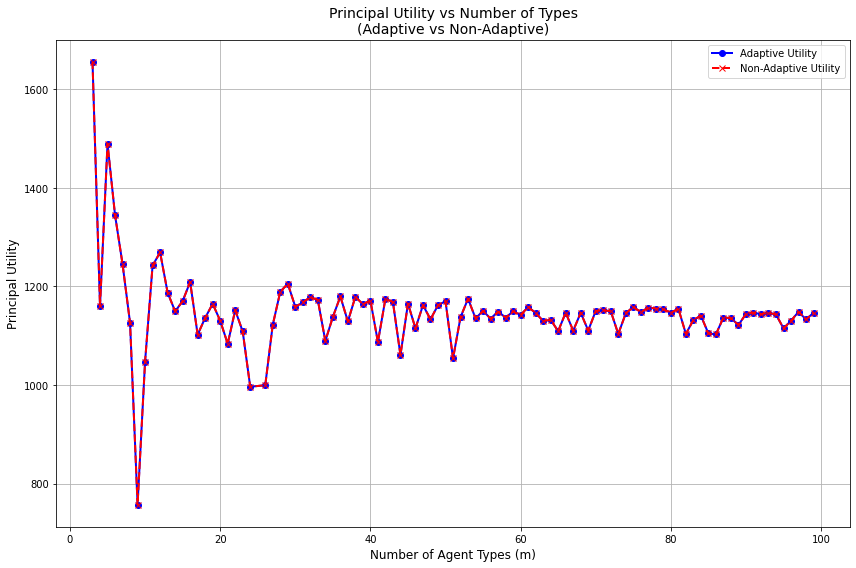

In [20]:
def simulate_number_of_types_effect(m_values, penalty_margin=0.5, epsilon=1e-8, cost=1.0):
    adaptive_utilities, non_adaptive_utilities, valid_m = [], [], []

    for m in m_values:
        num_agents, m, type_dist, payments, penalties = initialize_parameters(m=m, penalty_margin=penalty_margin)

        adaptive_util, audit_ad = optimal_adaptive_policy(type_dist, payments, penalties, cost, m, num_agents)
        non_adaptive_util, audit_na = optimal_non_adaptive_policy(type_dist, payments, penalties, cost, m, num_agents, epsilon)

        adaptive_checks = verify_assumptions(payments, penalties, cost, type_dist, audit_ad, epsilon=None)
        non_adaptive_checks = verify_assumptions(payments, penalties, cost, type_dist, audit_na, epsilon=epsilon)

        if not all(adaptive_checks):
            print(f"Adaptive assumptions violated at m={m}: {adaptive_checks}")
            continue
        if not all(non_adaptive_checks):
            print(f"Non-Adaptive assumptions violated at m={m}: {non_adaptive_checks}")
            continue

        valid_m.append(m)
        adaptive_utilities.append(adaptive_util)
        non_adaptive_utilities.append(non_adaptive_util)

    if not valid_m:
        print("No valid scenarios found explicitly. Adjust parameters explicitly.")
        return

    # Explicit plot
    plt.figure(figsize=(12, 8))
    plt.plot(valid_m, adaptive_utilities, 'bo-', linewidth=2, label='Adaptive Utility')
    plt.plot(valid_m, non_adaptive_utilities, 'rx--', linewidth=2, label='Non-Adaptive Utility')

    plt.xlabel('Number of Agent Types (m)', fontsize=12)
    plt.ylabel('Principal Utility', fontsize=12)
    plt.title('Principal Utility vs Number of Types\n(Adaptive vs Non-Adaptive)', fontsize=14)
    plt.grid(True)
    plt.legend(fontsize=10, loc='best')

    plt.tight_layout()
    plt.savefig("number_of_types_effect.png", dpi=300)
    plt.show()

# Example explicit execution
if __name__ == "__main__":
    m_values = range(3, 100)  # explicitly varying number of types from 3 to 20
    simulate_number_of_types_effect(m_values)

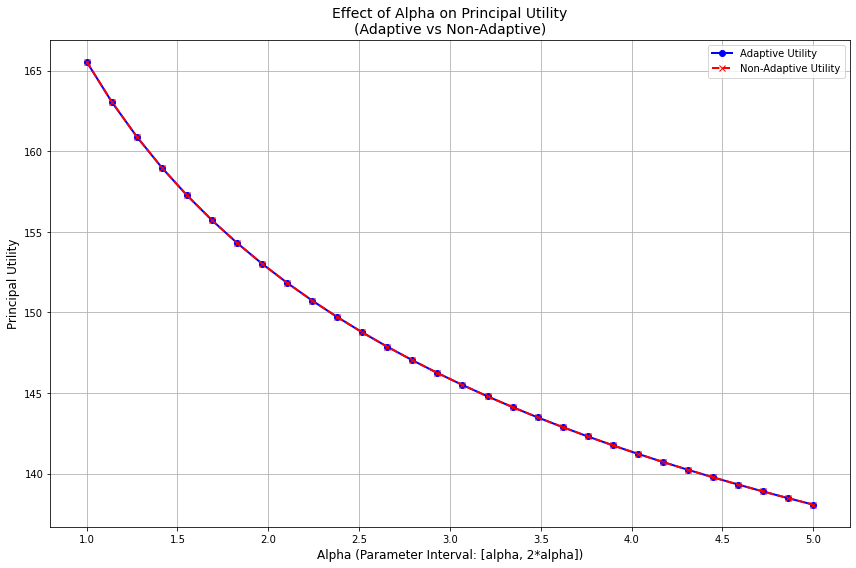

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Explicit parameter initialization with variable upper bound alpha
def initialize_parameters_variable_alpha(seed=7, num_agents=1000, m=3, penalty_margin=0.5, alpha=1.0):
    np.random.seed(seed)
    type_dist = np.random.dirichlet(np.random.uniform(alpha, 2*alpha, m))
    payments, penalties = generate_payments_and_penalties(type_dist, penalty_margin, m)
    return num_agents, m, type_dist, payments, penalties

# Generate payments and penalties explicitly from type distribution
def generate_payments_and_penalties(type_dist, penalty_margin, m):
    payments = np.zeros(m)
    cumulative = 0
    for i in range(m):
        cumulative += type_dist[i]
        payments[i] = 1 + cumulative / 2
    penalties = payments + penalty_margin
    return payments, penalties

# Valuation function explicitly as given by user
def valuation_function(i, k, payments):
    if k == i:
        return payments[i]
    elif k > i:
        return max(payments[i] - 0.2 * (k - i), 0.0)
    else:
        return max(payments[i] - 0.4 * (i - k), 0.0)

# Principal utility explicitly as given by user
def principal_utility(type_dist, audit_vector, cost, equilibrium_strategy, num_agents, payments, penalties):
    utility = 0
    for idx in range(len(type_dist)):
        reported_type = equilibrium_strategy[idx]
        valuation = valuation_function(idx, reported_type, payments)
        utility += type_dist[idx] * (
            valuation
            - payments[reported_type]
            + audit_vector[reported_type] * (penalties[reported_type] - cost)
        )
    return utility * num_agents

# Equilibrium strategy explicitly as given by user
def determine_equilibrium_strategy(payments, penalties, audit_vector, epsilon):
    u_hat = np.max(payments - audit_vector * penalties)
    A_hat = np.where(payments - audit_vector * penalties >= u_hat - epsilon)[0]
    equilibrium_strategy = np.zeros(len(payments), int)
    for idx in range(len(payments)):
        truthful_util = payments[idx]
        equilibrium_strategy[idx] = idx if truthful_util >= u_hat - epsilon else np.min(A_hat)
    return equilibrium_strategy

# Optimal adaptive policy explicitly as given by user
def optimal_adaptive_policy(type_dist, payments, penalties, cost, m, num_agents):
    best_utility = -np.inf
    optimal_audit_vector = np.zeros(m)
    candidate_us = np.concatenate((payments, payments))
    epsilon = 0
    for u in candidate_us:
        audit_vector = np.clip((payments - u) / penalties, 0, 1)
        eq_strategy = determine_equilibrium_strategy(payments, penalties, audit_vector, epsilon)
        utility = principal_utility(type_dist, audit_vector, cost, eq_strategy, num_agents, payments, penalties)
        if utility > best_utility:
            best_utility = utility
            optimal_audit_vector = audit_vector.copy()
    return best_utility, optimal_audit_vector

# Optimal non-adaptive policy explicitly as given by user
def optimal_non_adaptive_policy(type_dist, payments, penalties, cost, m, num_agents, epsilon):
    best_utility = -np.inf
    optimal_audit_vector = np.zeros(m)
    candidate_us = np.concatenate((payments + epsilon, payments - epsilon))
    for u in candidate_us:
        audit_vector = np.clip((payments - u) / penalties, 0, 1)
        eq_strategy = determine_equilibrium_strategy(payments, penalties, audit_vector, epsilon)
        utility = principal_utility(type_dist, audit_vector, cost, eq_strategy, num_agents, payments, penalties)
        if utility > best_utility:
            best_utility = utility
            optimal_audit_vector = audit_vector.copy()
    return best_utility, optimal_audit_vector

# Verify assumptions explicitly as given by user
def verify_assumptions(payments, penalties, cost, type_dist, audit_vector, epsilon=None):
    A1 = np.all(cost <= penalties)
    A2 = np.all(np.diff(payments) / payments[:-1] >= np.diff(penalties) / penalties[:-1])
    A3 = np.all(np.diff(payments) >= 0)
    A4 = np.all(penalties >= payments)
    A5 = np.isclose(np.sum(type_dist), 1)
    min_payment_diff = np.min(np.diff(payments))
    A6 = (epsilon is None) or (0 < epsilon < 0.5 * min_payment_diff)
    A7 = np.all((audit_vector >= 0) & (audit_vector <= 1))
    return A1, A2, A3, A4, A5, A6, A7

# Explicit simulation varying alpha explicitly
def simulate_effect_of_alpha(m=3, penalty_margin=0.5, epsilon=1e-6, cost=1.0, alpha_values=np.linspace(1, 5, 30)):
    adaptive_utils, non_adaptive_utils, valid_alphas = [], [], []

    for alpha in alpha_values:
        num_agents, m, type_dist, payments, penalties = initialize_parameters_variable_alpha(
            m=m, penalty_margin=penalty_margin, alpha=alpha)

        adaptive_util, adaptive_audit = optimal_adaptive_policy(
            type_dist, payments, penalties, cost, m, num_agents)
        non_adaptive_util, non_adaptive_audit = optimal_non_adaptive_policy(
            type_dist, payments, penalties, cost, m, num_agents, epsilon)

        adaptive_checks = verify_assumptions(payments, penalties, cost, type_dist, adaptive_audit, epsilon=None)
        non_adaptive_checks = verify_assumptions(payments, penalties, cost, type_dist, non_adaptive_audit, epsilon)

        if not all(adaptive_checks):
            print(f"Adaptive assumptions violated at alpha={alpha:.3f}: {adaptive_checks}")
            continue
        if not all(non_adaptive_checks):
            print(f"Non-Adaptive assumptions violated at alpha={alpha:.3f}: {non_adaptive_checks}")
            continue

        valid_alphas.append(alpha)
        adaptive_utils.append(adaptive_util)
        non_adaptive_utils.append(non_adaptive_util)

    if not valid_alphas:
        print("No valid scenarios explicitly found. Please explicitly adjust parameters.")
        return

    # Explicit plotting of results
    plt.figure(figsize=(12, 8))
    plt.plot(valid_alphas, adaptive_utils, 'bo-', linewidth=2, label='Adaptive Utility')
    plt.plot(valid_alphas, non_adaptive_utils, 'rx--', linewidth=2, label='Non-Adaptive Utility')

    plt.xlabel('Alpha (Parameter Interval: [alpha, 2*alpha])', fontsize=12)
    plt.ylabel('Principal Utility', fontsize=12)
    plt.title('Effect of Alpha on Principal Utility\n(Adaptive vs Non-Adaptive)', fontsize=14)
    plt.grid(True)
    plt.legend(fontsize=10, loc='best')
    plt.tight_layout()
    plt.savefig("principal_utility_vs_alpha.png", dpi=300)
    plt.show()

# Example execution explicitly
if __name__ == "__main__":
    simulate_effect_of_alpha()


# 3 agent 3 D figure

In [12]:
from mpl_toolkits.mplot3d import Axes3D

In [24]:
# Simulation for different proportions and epsilon values with simplified assumption checks
def run_simulation_3d(m=3, penalty_margin=0.5, cost=1.0):
    num_agents, m, _, payments, penalties = initialize_parameters(m=m, penalty_margin=penalty_margin)
    epsilon_values = [0.05, 0.01, 0.001, 0.0001, 0.00001]  # Non-adaptive epsilon values

    proportions = np.linspace(0, 1, 20)
    X, Y = np.meshgrid(proportions, proportions)

    fig = plt.figure(figsize=(20, 15))

    for idx, eps in enumerate(epsilon_values, start=1):
        Z_adaptive = np.zeros_like(X)
        Z_non_adaptive = np.zeros_like(X)

        violation_reported = False

        for i in range(len(proportions)):
            for j in range(len(proportions)):
                if X[i, j] + Y[i, j] <= 1:
                    type_dist = np.array([X[i, j], Y[i, j], 1 - X[i, j] - Y[i, j]])

                    utility_na, audit_vector_na = optimal_non_adaptive_policy(type_dist, payments, penalties, cost, m, num_agents, epsilon=eps)
                    utility_ad, audit_vector_ad = optimal_adaptive_policy(type_dist, payments, penalties, cost, m, num_agents)

                    if not violation_reported:
                        A1, A2, A3, A4, A5, A6, A7_na = verify_assumptions(payments, penalties, cost, type_dist, audit_vector_na, epsilon=eps)
                        _, _, _, _, _, _, A7_ad = verify_assumptions(payments, penalties, cost, type_dist, audit_vector_ad, epsilon=0)

                        if not (A1 and A2 and A3 and A4 and A5 and A6 and A7_na):
                            print(f"Warning: Non-adaptive assumptions violated at epsilon={eps}")
                            violation_reported = True

                        if not (A1 and A2 and A3 and A4 and A5 and A7_ad):
                            print(f"Warning: Adaptive assumptions violated at epsilon=0")
                            violation_reported = True

                    Z_non_adaptive[i, j] = utility_na
                    Z_adaptive[i, j] = utility_ad
                else:
                    Z_non_adaptive[i, j] = np.nan
                    Z_adaptive[i, j] = np.nan

        ax = fig.add_subplot(2, 3, idx, projection='3d')
        ax.plot_surface(X, Y, Z_adaptive, color='blue', alpha=0.7, label='Adaptive (epsilon=0)')
        ax.plot_surface(X, Y, Z_non_adaptive, color='red', alpha=0.7, label=f'Non-Adaptive (epsilon={eps})')

        ax.set_title(f"Adaptive (ε=0, blue) vs Non-Adaptive (ε={eps}, red)", fontsize=14)
        ax.set_xlabel('Proportion of Type 0', fontsize=12)
        ax.set_ylabel('Proportion of Type 1', fontsize=12)
        ax.set_zlabel('Principal Utility', fontsize=12)
        ax.view_init(elev=30, azim=120)

    plt.tight_layout()
    plt.savefig("adaptive_vs_nonadaptive_utilities.png", dpi=300)
    plt.show()

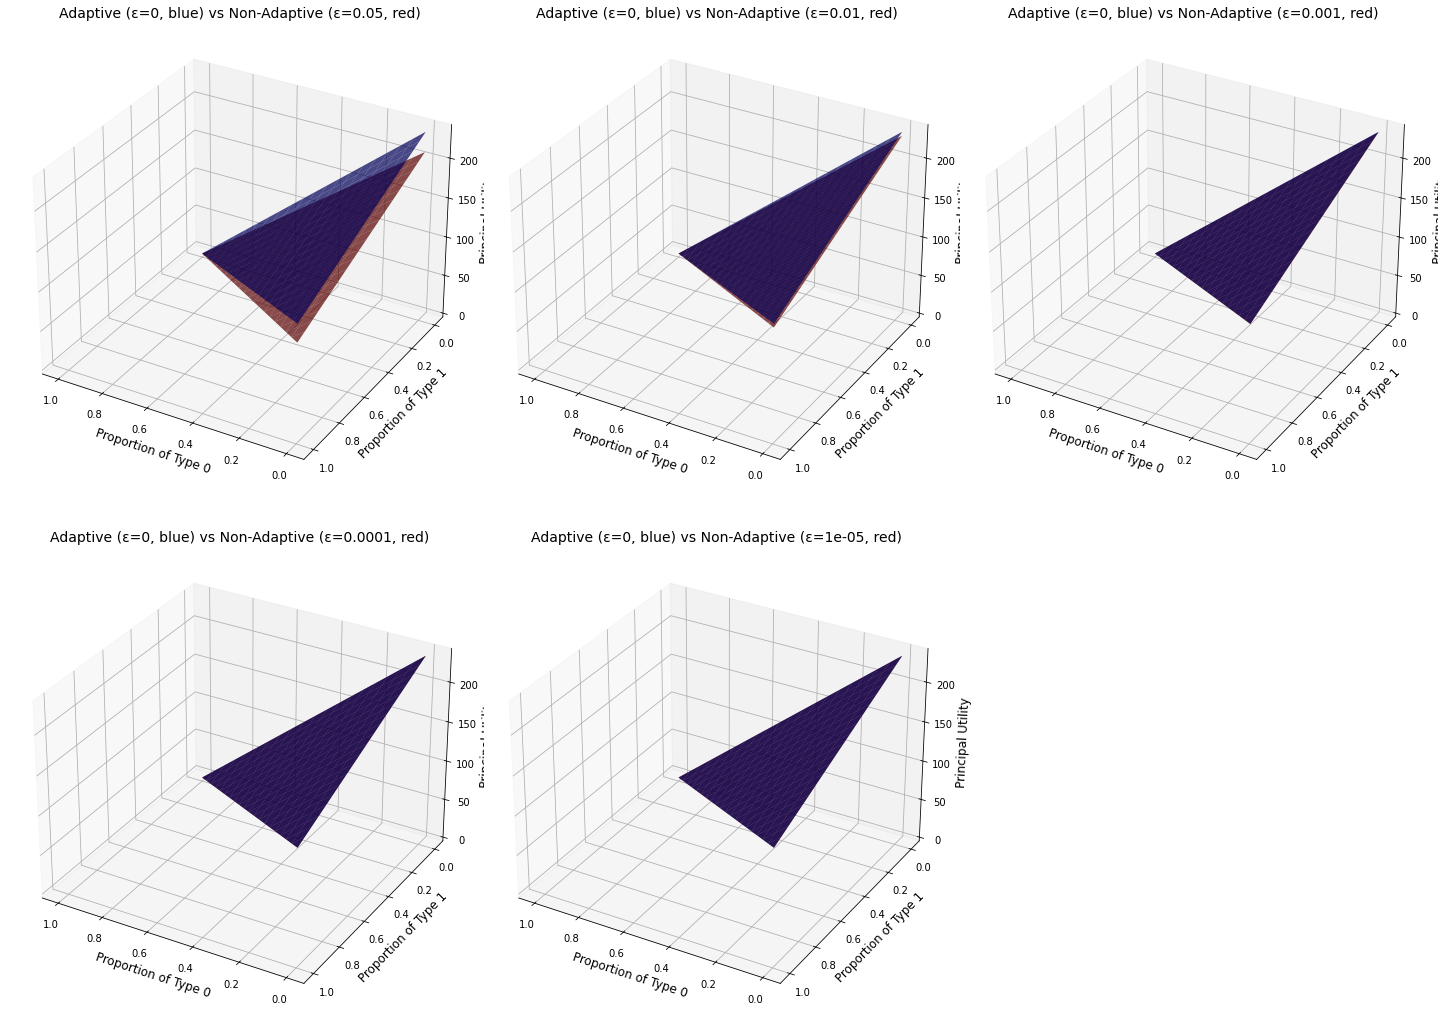

In [25]:
if __name__ == "__main__":
    run_simulation_3d()

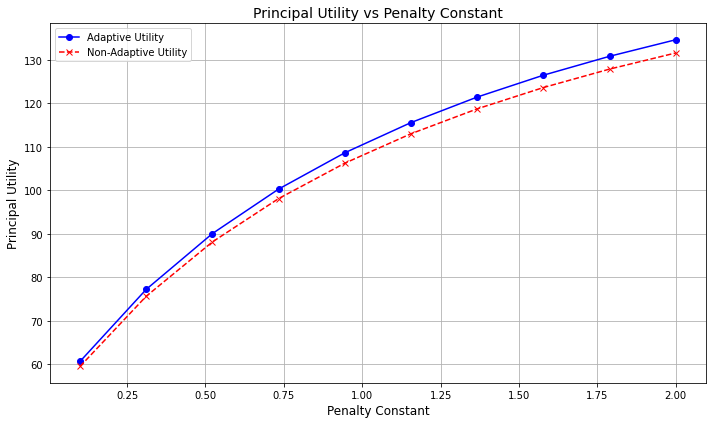

In [52]:
# Simulation function to analyze principal's utility with varying penalty constants
def run_simulation_varying_penalty(m=8, cost=1.0, epsilon=0.005, penalty_constants=np.linspace(0.1, 2, 10)):
    num_agents, m, _, payments, _ = initialize_parameters(m=m)

    proportions = np.linspace(0, 1, 20)
    X, Y = np.meshgrid(proportions, proportions)

    adaptive_utilities = np.zeros(len(penalty_constants))
    non_adaptive_utilities = np.zeros(len(penalty_constants))

    type_dist = np.array([1/m]*m)  # Explicit uniform distribution for simplicity

    for idx, penalty_margin in enumerate(penalty_constants):
        penalties = payments + penalty_margin

        adaptive_utility, audit_vector_ad = optimal_adaptive_policy(
            type_dist, payments, penalties, cost, m, num_agents
        )
        non_adaptive_utility, audit_vector_na = optimal_non_adaptive_policy(
            type_dist, payments, penalties, cost, m, num_agents, epsilon
        )

        adaptive_utilities[idx] = adaptive_utility
        non_adaptive_utilities[idx] = non_adaptive_utility

        # Explicitly verify assumptions
        A1, A2, A3, A4, A5, A6, A7_na = verify_assumptions(
            payments, penalties, cost, type_dist, audit_vector_na, epsilon
        )
        _, _, _, _, _, _, A7_ad = verify_assumptions(
            payments, penalties, cost, type_dist, audit_vector_ad, epsilon=0
        )

        if not (A1 and A2 and A3 and A4 and A5 and A6 and A7_na):
            print(f"Non-adaptive assumptions violated at penalty_margin={penalty_margin}")
        if not (A1 and A2 and A3 and A4 and A5 and A7_ad):
            print(f"Adaptive assumptions violated at penalty_margin={penalty_margin}")

    # Plot results explicitly
    plt.figure(figsize=(10, 6))
    plt.plot(penalty_constants, adaptive_utilities, 'o-', color='blue', label='Adaptive Utility')
    plt.plot(penalty_constants, non_adaptive_utilities, 'x--', color='red', label='Non-Adaptive Utility')

    plt.xlabel('Penalty Constant', fontsize=12)
    plt.ylabel('Principal Utility', fontsize=12)
    plt.title('Principal Utility vs Penalty Constant', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("principal_utility_vs_penalty_constant.png", dpi=300)
    plt.show()

# Example explicit execution
if __name__ == "__main__":
    run_simulation_varying_penalty()


# audit cost affect on equilibrium sudden change

C:\Users\arche\AppData\Local\Temp\ipykernel_18036\2365597371.py:68: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([adaptive_left_costs[-1], adaptive_bc], [adaptive_left_utils[-1], adaptive_left_limit], 'b-', linewidth=1, linestyle='--')
C:\Users\arche\AppData\Local\Temp\ipykernel_18036\2365597371.py:69: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([adaptive_bc, adaptive_right_costs[0]], [adaptive_right_limit, adaptive_right_utils[0]], 'b-', linewidth=1, linestyle='--')
C:\Users\arche\AppData\Local\Temp\ipykernel_18036\2365597371.py:76: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([non_ad

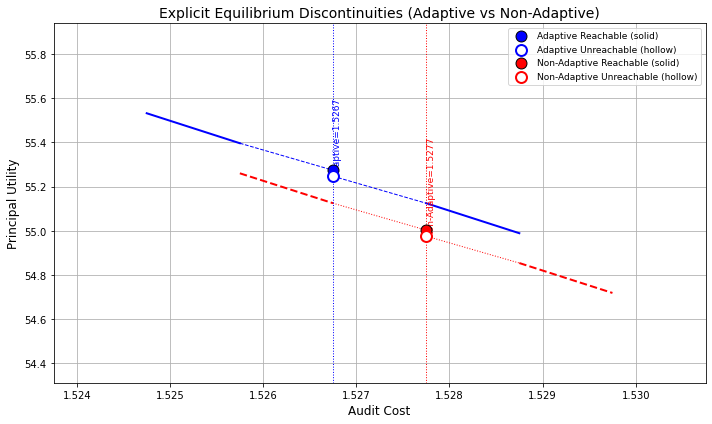

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_adaptive_nonadaptive_discontinuity(m=3, penalty_margin=0.5, epsilon=1e-3, delta=1e-3):
    num_agents, m, _, payments, penalties = initialize_parameters(m=m, penalty_margin=penalty_margin)
    type_dist = np.array([1/m]*m)

    def compute_boundary_costs(payments, penalties, eps):
        boundaries = set()
        for i in range(m - 1):
            critical_us = [payments[i] + eps, payments[i+1] - eps]
            for u in critical_us:
                for k in range(i, m):
                    bc = penalties[k] - (payments[k] - u)
                    if bc >= 0:
                        boundaries.add(bc)
        return sorted(boundaries)

    adaptive_boundaries = compute_boundary_costs(payments, penalties, 0)
    non_adaptive_boundaries = compute_boundary_costs(payments, penalties, epsilon)

    if not adaptive_boundaries or not non_adaptive_boundaries:
        print("No boundary points found.")
        return

    adaptive_bc = adaptive_boundaries[0]
    non_adaptive_bc = min(non_adaptive_boundaries, key=lambda x: abs(x - adaptive_bc))

    # Points around adaptive boundary
    adaptive_left_costs = [adaptive_bc - 2*delta, adaptive_bc - delta]
    adaptive_right_costs = [adaptive_bc + delta, adaptive_bc + 2*delta]

    # Points around non-adaptive boundary
    non_adaptive_left_costs = [non_adaptive_bc - 2*delta, non_adaptive_bc - delta]
    non_adaptive_right_costs = [non_adaptive_bc + delta, non_adaptive_bc + 2*delta]

    # Calculate utilities 
    def calculate_utilities(costs, adaptive):
        utilities = []
        for c in costs:
            if adaptive:
                util, _ = optimal_adaptive_policy(type_dist, payments, penalties, c, m, num_agents)
            else:
                util, _ = optimal_non_adaptive_policy(type_dist, payments, penalties, c, m, num_agents, epsilon)
            utilities.append(util)
        return utilities

    adaptive_left_utils = calculate_utilities(adaptive_left_costs, adaptive=True)
    adaptive_right_utils = calculate_utilities(adaptive_right_costs, adaptive=True)

    non_adaptive_left_utils = calculate_utilities(non_adaptive_left_costs, adaptive=False)
    non_adaptive_right_utils = calculate_utilities(non_adaptive_right_costs, adaptive=False)

    # Evaluate limits  at the boundary cost
    adaptive_left_limit, _ = optimal_adaptive_policy(type_dist, payments, penalties, adaptive_bc - delta/10, m, num_agents)
    adaptive_right_limit, _ = optimal_adaptive_policy(type_dist, payments, penalties, adaptive_bc + delta/10, m, num_agents)

    non_adaptive_left_limit, _ = optimal_non_adaptive_policy(type_dist, payments, penalties, non_adaptive_bc - delta/10, m, num_agents, epsilon)
    non_adaptive_right_limit, _ = optimal_non_adaptive_policy(type_dist, payments, penalties, non_adaptive_bc + delta/10, m, num_agents, epsilon)

    plt.figure(figsize=(10, 6))

    # Adaptive utility lines and points 
    plt.plot(adaptive_left_costs, adaptive_left_utils, 'b-', linewidth=2)
    plt.plot(adaptive_right_costs, adaptive_right_utils, 'b-', linewidth=2)

    # Connect limits
    plt.plot([adaptive_left_costs[-1], adaptive_bc], [adaptive_left_utils[-1], adaptive_left_limit], 'b-', linewidth=1, linestyle='--')
    plt.plot([adaptive_bc, adaptive_right_costs[0]], [adaptive_right_limit, adaptive_right_utils[0]], 'b-', linewidth=1, linestyle='--')

    # Non-adaptive utility lines and points 
    plt.plot(non_adaptive_left_costs, non_adaptive_left_utils, 'r--', linewidth=2)
    plt.plot(non_adaptive_right_costs, non_adaptive_right_utils, 'r--', linewidth=2)

    # Connect limits 
    plt.plot([non_adaptive_left_costs[-1], non_adaptive_bc], [non_adaptive_left_utils[-1], non_adaptive_left_limit], 'r--', linewidth=1, linestyle=':')
    plt.plot([non_adaptive_bc, non_adaptive_right_costs[0]], [non_adaptive_right_limit, non_adaptive_right_utils[0]], 'r--', linewidth=1, linestyle=':')

    # Mark limit points 
    plt.scatter(adaptive_bc, adaptive_left_limit, color='blue', edgecolor='black', s=120, zorder=5, label='Adaptive Reachable (solid)')
    plt.scatter(adaptive_bc, adaptive_right_limit, facecolors='white', edgecolors='blue', s=120, linewidth=2, zorder=5, label='Adaptive Unreachable (hollow)')

    plt.scatter(non_adaptive_bc, non_adaptive_left_limit, color='red', edgecolor='black', s=120, zorder=5, label='Non-Adaptive Reachable (solid)')
    plt.scatter(non_adaptive_bc, non_adaptive_right_limit, facecolors='white', edgecolors='red', s=120, linewidth=2, zorder=5, label='Non-Adaptive Unreachable (hollow)')

    # Annotate boundary costs 
    plt.axvline(adaptive_bc, linestyle=':', color='blue', linewidth=1)
    plt.text(adaptive_bc, min(adaptive_left_limit, adaptive_right_limit), f'Adaptive={adaptive_bc:.4f}', rotation=90, fontsize=9, verticalalignment='bottom', color='blue')

    plt.axvline(non_adaptive_bc, linestyle=':', color='red', linewidth=1)
    plt.text(non_adaptive_bc, min(non_adaptive_left_limit, non_adaptive_right_limit), f'Non-Adaptive={non_adaptive_bc:.4f}', rotation=90, fontsize=9, verticalalignment='bottom', color='red')

    # plot limits for clarity
    plt.xlim(min(adaptive_bc, non_adaptive_bc) - 3*delta, max(adaptive_bc, non_adaptive_bc) + 3*delta)
    all_utilities = adaptive_left_utils + adaptive_right_utils + [adaptive_left_limit, adaptive_right_limit] + non_adaptive_left_utils + non_adaptive_right_utils + [non_adaptive_left_limit, non_adaptive_right_limit]
    util_margin = (max(all_utilities) - min(all_utilities)) * 0.5
    plt.ylim(min(all_utilities)-util_margin, max(all_utilities)+util_margin)

    #labels and legend
    plt.xlabel('Audit Cost', fontsize=12)
    plt.ylabel('Principal Utility', fontsize=12)
    plt.title('Explicit Equilibrium Discontinuities (Adaptive vs Non-Adaptive)', fontsize=14)
    plt.grid(True)

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), fontsize=9)

    plt.tight_layout()
    plt.savefig('explicit_equilibrium_discontinuity.png', dpi=300)
    plt.show()

if __name__ == "__main__":
    simulate_adaptive_nonadaptive_discontinuity()


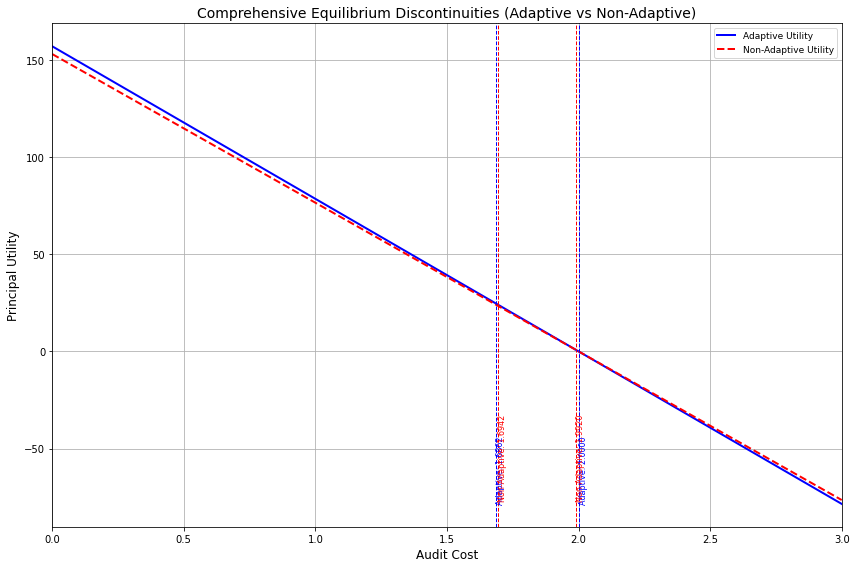

In [70]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_comprehensive_equilibrium(m=2, penalty_margin=0.5, epsilon=0.008, num_points=10):
    num_agents, m, _, payments, penalties = initialize_parameters(m=m, penalty_margin=penalty_margin)
    type_dist = np.array([1/m] * m)

    cost_values = np.linspace(0, max(penalties) + 1, num_points)
    adaptive_utils, non_adaptive_utils = [], []

    # Compute explicit utilities across full range
    for cost in cost_values:
        ad_util, _ = optimal_adaptive_policy(type_dist, payments, penalties, cost, m, num_agents)
        na_util, _ = optimal_non_adaptive_policy(type_dist, payments, penalties, cost, m, num_agents, epsilon)
        adaptive_utils.append(ad_util)
        non_adaptive_utils.append(na_util)

    # Explicitly compute boundary points using formula (no search)
    def compute_boundary_costs(payments, penalties, eps):
        boundaries = set()
        for i in range(m - 1):
            critical_us = [payments[i] + eps, payments[i + 1] - eps]
            for u in critical_us:
                for k in range(i, m):
                    boundary_cost = penalties[k] - (payments[k] - u)
                    if 0 <= boundary_cost <= max(cost_values):
                        boundaries.add(boundary_cost)
        return sorted(boundaries)

    adaptive_boundaries = compute_boundary_costs(payments, penalties, 0)
    non_adaptive_boundaries = compute_boundary_costs(payments, penalties, epsilon)

    all_boundaries = sorted(set(adaptive_boundaries + non_adaptive_boundaries))

    plt.figure(figsize=(12, 8))
    plt.plot(cost_values, adaptive_utils, 'b-', linewidth=2, label='Adaptive Utility')
    plt.plot(cost_values, non_adaptive_utils, 'r--', linewidth=2, label='Non-Adaptive Utility')

    # Explicitly mark and annotate all boundary points
    for bc in adaptive_boundaries:
        plt.axvline(x=bc, linestyle='--', color='blue', linewidth=1)
        plt.text(bc, min(adaptive_utils), f'Adaptive: {bc:.4f}', rotation=90, fontsize=8, color='blue', verticalalignment='bottom')

    for bc in non_adaptive_boundaries:
        plt.axvline(x=bc, linestyle='--', color='red', linewidth=1)
        plt.text(bc, min(non_adaptive_utils)-0.5, f'Non-Adaptive: {bc:.4f}', rotation=90, fontsize=8, color='red', verticalalignment='bottom')

    plt.xlabel('Audit Cost', fontsize=12)
    plt.ylabel('Principal Utility', fontsize=12)
    plt.title('Comprehensive Equilibrium Discontinuities (Adaptive vs Non-Adaptive)', fontsize=14)
    plt.grid(True)

    plt.xlim(min(cost_values), max(cost_values))
    all_utils = adaptive_utils + non_adaptive_utils
    margin = (max(all_utils) - min(all_utils)) * 0.05
    plt.ylim(min(all_utils)-margin, max(all_utils)+margin)

    # Explicitly set legend
    plt.legend(fontsize=9, loc='best')
    plt.tight_layout()
    plt.savefig('comprehensive_equilibrium_discontinuities_final.png', dpi=300)
    plt.show()

if __name__ == "__main__":
    simulate_comprehensive_equilibrium()


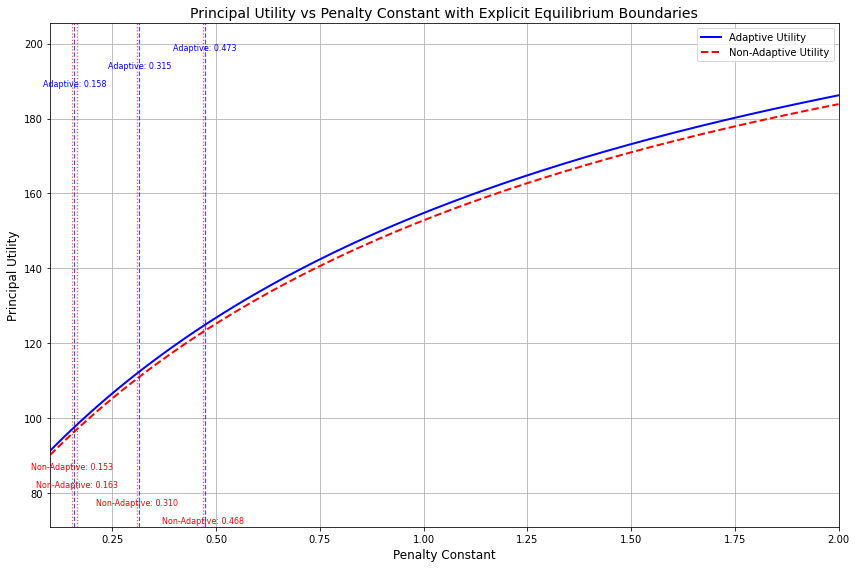

In [73]:
import numpy as np
import matplotlib.pyplot as plt

def run_simulation_varying_penalty(m=3, cost=1.0, epsilon=0.005, num_points=500, delta=1e-4):
    num_agents, m, _, payments, _ = initialize_parameters(m=m)
    type_dist = np.array([1/m]*m)

    penalty_constants = np.linspace(0.1, 2, num_points)
    adaptive_utils, non_adaptive_utils = [], []

    # Compute utilities across the penalty range explicitly
    for penalty_margin in penalty_constants:
        penalties = payments + penalty_margin
        adaptive_util, _ = optimal_adaptive_policy(type_dist, payments, penalties, cost, m, num_agents)
        adaptive_utils.append(adaptive_util)
        
        non_adaptive_util, _ = optimal_non_adaptive_policy(type_dist, payments, penalties, cost, m, num_agents, epsilon)
        non_adaptive_utils.append(non_adaptive_util)

    # Compute equilibrium boundary penalty points explicitly (no search)
    def compute_boundary_penalty_constants(payments, eps):
        boundaries = set()
        for i in range(m - 1):
            critical_us = [payments[i] + eps, payments[i+1] - eps]
            for u in critical_us:
                for k in range(i, m):
                    boundary_penalty = payments[k] - u
                    if boundary_penalty >= 0:
                        boundaries.add(boundary_penalty)
        return sorted(boundaries)

    adaptive_boundaries = compute_boundary_penalty_constants(payments, eps=0)
    non_adaptive_boundaries = compute_boundary_penalty_constants(payments, eps=epsilon)

    # Begin explicit plotting
    plt.figure(figsize=(12, 8))
    plt.plot(penalty_constants, adaptive_utils, 'b-', linewidth=2, label='Adaptive Utility')
    plt.plot(penalty_constants, non_adaptive_utils, 'r--', linewidth=2, label='Non-Adaptive Utility')

    ymin, ymax = min(non_adaptive_utils), max(adaptive_utils)
    y_range = ymax - ymin

    # Function to explicitly manage label positions to prevent overlap
    def plot_boundaries(boundaries, color, linestyle, y_initial, y_step, label_prefix):
        y_text_positions = []
        for boundary in boundaries:
            if penalty_constants[0] <= boundary <= penalty_constants[-1]:
                plt.axvline(boundary, color=color, linestyle=linestyle, linewidth=1.2, alpha=0.7)
                
                # Find a vertical position that avoids overlap explicitly
                y_text = y_initial
                while any(abs(y_text - y_pos) < 0.03 * y_range for y_pos in y_text_positions):
                    y_text += y_step
                
                y_text_positions.append(y_text)
                
                plt.text(boundary, y_text, f'{label_prefix}{boundary:.3f}', rotation=0,
                         fontsize=8, color=color,
                         verticalalignment='bottom' if y_step > 0 else 'top',
                         horizontalalignment='center')

    # Adaptive boundaries with horizontal labels explicitly positioned at the top
    plot_boundaries(adaptive_boundaries, 'blue', '--', ymax + 0.02 * y_range, 0.05 * y_range, 'Adaptive: ')

    # Non-adaptive boundaries with horizontal labels explicitly positioned at the bottom
    plot_boundaries(non_adaptive_boundaries, 'red', ':', ymin - 0.02 * y_range, -0.05 * y_range, 'Non-Adaptive: ')

    # Explicit axis labeling and formatting
    plt.xlabel('Penalty Constant', fontsize=12)
    plt.ylabel('Principal Utility', fontsize=12)
    plt.title('Principal Utility vs Penalty Constant with Explicit Equilibrium Boundaries', fontsize=14)
    plt.grid(True)

    plt.xlim(min(penalty_constants), max(penalty_constants))
    plt.ylim(ymin - 0.2 * y_range, ymax + 0.2 * y_range)  # Extra margin explicitly for labels

    plt.legend(fontsize=10, loc='best')
    plt.tight_layout()
    plt.savefig("explicit_horizontal_labels_penalty_boundaries.png", dpi=300)
    plt.show()

if __name__ == "__main__":
    run_simulation_varying_penalty()


# payments gap affect on optiaml utility

# 1. pay(1) -pay(0)

In [23]:
def explicitly_initialize_payments(m, base_payment=1.0, initial_gap=0.02, gap_increase=0.02):
    payments = np.zeros(m)
    payments[0] = base_payment
    payments[1] = payments[0] + initial_gap
    for i in range(2, m):
        payments[i] = payments[i-1] + gap_increase
    return payments

In [24]:
def verify_assumptions(payments, penalties, cost, type_dist, audit_vector, epsilon=None):
    A1 = np.all(cost <= penalties)
    A2 = np.all(np.diff(payments) / payments[:-1] >= np.diff(penalties) / penalties[:-1])
    A3 = np.all(np.diff(payments) >= 0)
    A4 = np.all(penalties >= payments)
    A5 = np.isclose(np.sum(type_dist), 1)

    min_payment_diff = np.min(np.diff(payments))
    
    if epsilon is not None:
        A6 = (0 < epsilon < 0.5 * min_payment_diff)
    else:
        A6 = True  # explicitly adaptive case has no epsilon requirement

    A7 = np.all((audit_vector >= 0) & (audit_vector <= 1))

    return A1, A2, A3, A4, A5, A6, A7

In [37]:
def simulate_payment_gap_effect_validated(
    m=3, penalty_margin=0.5, epsilon=0.01, gap_values=np.linspace(0.02, 1, 50), cost=1.0):
    
    num_agents, m, _, _, _ = initialize_parameters(m=m)
    type_dist = np.array([1/m]*m)

    adaptive_utilities, non_adaptive_utilities, valid_gaps = [], [], []

    for gap in gap_values:
        payments = explicitly_initialize_payments(m, base_payment=1.0, initial_gap=gap, gap_increase=0.02)
        penalties = payments + penalty_margin

        adaptive_util, adaptive_policy = optimal_adaptive_policy(
            type_dist, payments, penalties, cost, m, num_agents)

        non_adaptive_util, non_adaptive_policy = optimal_non_adaptive_policy(
            type_dist, payments, penalties, cost, m, num_agents, epsilon)

        min_payment_diff = np.min(np.diff(payments))

        # Explicit debug print
        A6_debug = (0 < epsilon < 0.5 * min_payment_diff)
        print(f"Debug (gap={gap:.3f}): min_payment_diff={min_payment_diff:.6f}, epsilon={epsilon}, A6_condition={A6_debug}")

        # Check adaptive assumptions explicitly (epsilon=None explicitly)
        assumptions_adaptive = verify_assumptions(
            payments, penalties, cost, type_dist, adaptive_policy, epsilon=None)
        if not all(assumptions_adaptive):
            print(f"Adaptive violation at gap={gap:.3f}: {assumptions_adaptive}")
            continue

        # Check non-adaptive assumptions explicitly (epsilon provided explicitly)
        assumptions_non_adaptive = verify_assumptions(
            payments, penalties, cost, type_dist, non_adaptive_policy, epsilon=epsilon)
        if not all(assumptions_non_adaptive):
            print(f"Non-Adaptive violation at gap={gap:.3f}: {assumptions_non_adaptive}")
            continue

        # Explicitly store valid results
        valid_gaps.append(gap)
        adaptive_utilities.append(adaptive_util)
        non_adaptive_utilities.append(non_adaptive_util)

    if not valid_gaps:
        print("No valid scenarios found explicitly. Please explicitly adjust parameters.")
        return

    # Explicit plotting of valid results
    plt.figure(figsize=(12, 8))
    plt.plot(valid_gaps, adaptive_utilities, 'bo-', linewidth=2, label='Adaptive Utility')
    plt.plot(valid_gaps, non_adaptive_utilities, 'rx--', linewidth=2, label='Non-Adaptive Utility')

    plt.xlabel('Payment Gap pay(1)-pay(0)', fontsize=12)
    plt.ylabel('Principal Utility', fontsize=12)
    plt.title('Principal Utility vs Payment Gap (Explicitly Validated)', fontsize=14)
    plt.grid(True)
    plt.legend(fontsize=10, loc='best')
    plt.tight_layout()
    plt.savefig('validated_payment_gap_effect.png', dpi=300)
    plt.show()

Debug (gap=0.020): min_payment_diff=0.020000, epsilon=0.01, A6_condition=True
Debug (gap=0.040): min_payment_diff=0.020000, epsilon=0.01, A6_condition=True
Debug (gap=0.060): min_payment_diff=0.020000, epsilon=0.01, A6_condition=True
Debug (gap=0.080): min_payment_diff=0.020000, epsilon=0.01, A6_condition=True
Debug (gap=0.100): min_payment_diff=0.020000, epsilon=0.01, A6_condition=True
Debug (gap=0.120): min_payment_diff=0.020000, epsilon=0.01, A6_condition=True
Debug (gap=0.140): min_payment_diff=0.020000, epsilon=0.01, A6_condition=True
Debug (gap=0.160): min_payment_diff=0.020000, epsilon=0.01, A6_condition=True
Debug (gap=0.180): min_payment_diff=0.020000, epsilon=0.01, A6_condition=True
Debug (gap=0.200): min_payment_diff=0.020000, epsilon=0.01, A6_condition=True
Debug (gap=0.220): min_payment_diff=0.020000, epsilon=0.01, A6_condition=True
Debug (gap=0.240): min_payment_diff=0.020000, epsilon=0.01, A6_condition=True
Debug (gap=0.260): min_payment_diff=0.020000, epsilon=0.01, A6_c

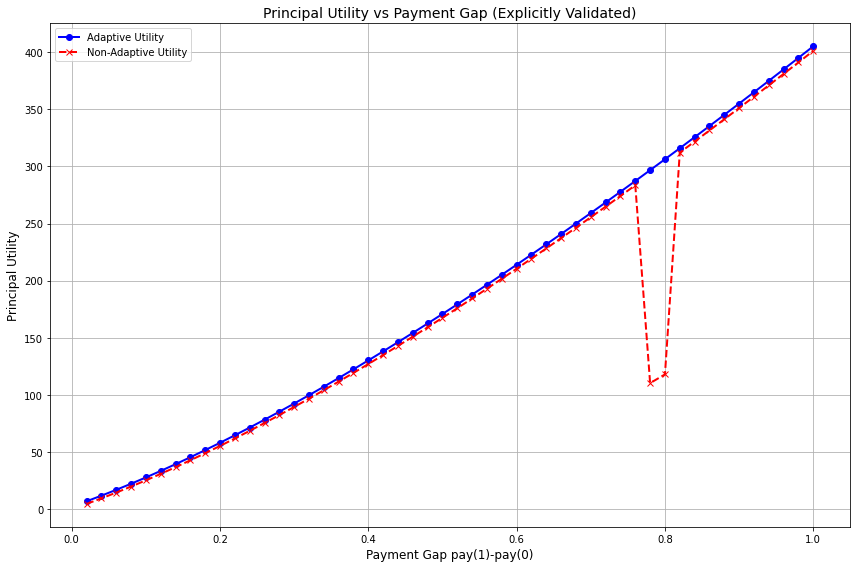

In [38]:
if __name__ == "__main__":
    simulate_payment_gap_effect_validated()

--- Non-Adaptive Equilibrium Change Detected at gap=0.660 ---
Previous Non-Adaptive Equilibrium: [0 1 2]
New Non-Adaptive Equilibrium: [1 1 2]
Audit Vector at gap=0.660: [1 1 2]
Principal Utility drop: from 231.793 to 72.320

--- Non-Adaptive Equilibrium Change Detected at gap=0.700 ---
Previous Non-Adaptive Equilibrium: [1 1 2]
New Non-Adaptive Equilibrium: [0 1 2]
Audit Vector at gap=0.700: [0 1 2]
Principal Utility drop: from 79.321 to 259.164



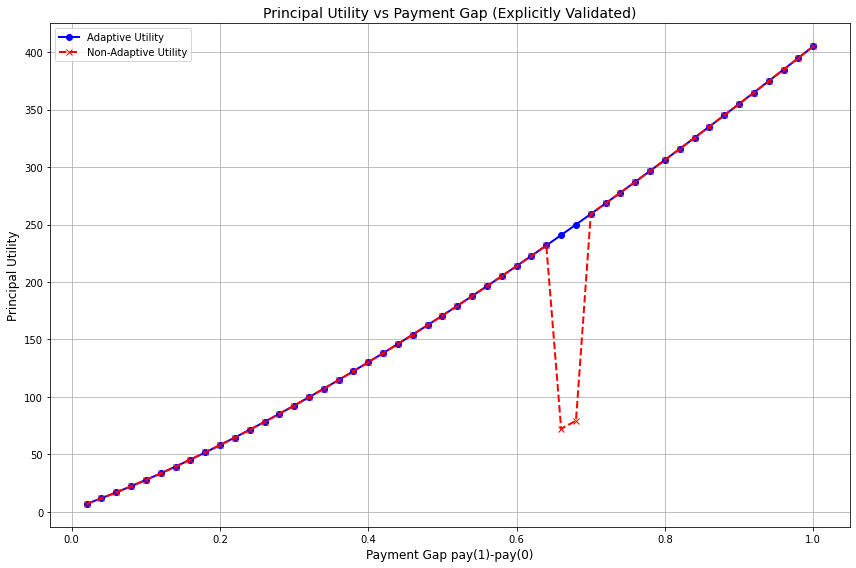

In [43]:
import numpy as np
import matplotlib.pyplot as plt

def explicitly_initialize_payments(m, base_payment=1.0, initial_gap=0.3, gap_increase=0.02):
    payments = np.zeros(m)
    payments[0] = base_payment
    payments[1] = payments[0] + initial_gap
    for i in range(2, m):
        payments[i] = payments[i - 1] + gap_increase
    return payments

def verify_assumptions(payments, penalties, cost, type_dist, audit_vector, epsilon=None):
    A1 = np.all(cost <= penalties)
    A2 = np.all(np.diff(payments) / payments[:-1] >= np.diff(penalties) / penalties[:-1])
    A3 = np.all(np.diff(payments) >= 0)
    A4 = np.all(penalties >= payments)
    A5 = np.isclose(np.sum(type_dist), 1)

    min_payment_diff = np.min(np.diff(payments))
    A6 = True if epsilon is None else (0 < epsilon < 0.5 * min_payment_diff)
    A7 = np.all((audit_vector >= 0) & (audit_vector <= 1))

    return A1, A2, A3, A4, A5, A6, A7

def optimal_strategy_info(type_dist, payments, penalties, cost, m, num_agents, epsilon):
    adaptive_util, adaptive_audit = optimal_adaptive_policy(type_dist, payments, penalties, cost, m, num_agents)
    adaptive_eq = determine_equilibrium_strategy(payments, penalties, adaptive_audit, epsilon=0)

    non_adaptive_util, non_adaptive_audit = optimal_non_adaptive_policy(type_dist, payments, penalties, cost, m, num_agents, epsilon)
    non_adaptive_eq = determine_equilibrium_strategy(payments, penalties, non_adaptive_audit, epsilon=epsilon)

    assumptions_adaptive = verify_assumptions(payments, penalties, cost, type_dist, adaptive_audit, epsilon=None)
    assumptions_non_adaptive = verify_assumptions(payments, penalties, cost, type_dist, non_adaptive_audit, epsilon=epsilon)

    return (adaptive_util, adaptive_eq, assumptions_adaptive,
            non_adaptive_util, non_adaptive_eq, assumptions_non_adaptive)

def simulate_and_debug_payment_gap(
    m=3, penalty_margin=0.5, epsilon=1e-6,
    gap_values=np.linspace(0.02, 1, 50), cost=1.0):

    num_agents, m, _, _, _ = initialize_parameters(m=m)
    type_dist = np.array([1/m] * m)

    adaptive_utils, non_adaptive_utils, valid_gaps = [], [], []
    prev_na_eq = None

    for gap in gap_values:
        payments = explicitly_initialize_payments(m, base_payment=1.0, initial_gap=gap, gap_increase=0.02)
        penalties = payments + penalty_margin

        (adaptive_util, adaptive_eq, adaptive_checks,
         non_adaptive_util, non_adaptive_eq, non_adaptive_checks) = optimal_strategy_info(
            type_dist, payments, penalties, cost, m, num_agents, epsilon)

        # verify all assumptions
        adaptive_valid = all(adaptive_checks)
        non_adaptive_valid = all(non_adaptive_checks)

        if not adaptive_valid:
            print(f"[Adaptive violation at gap={gap:.3f}] Assumptions: {adaptive_checks}")
            continue

        if not non_adaptive_valid:
            print(f"[Non-Adaptive violation at gap={gap:.3f}] Assumptions: {non_adaptive_checks}")
            continue

        # Check  for equilibrium change (non-adaptive)
        if prev_na_eq is not None and not np.array_equal(non_adaptive_eq, prev_na_eq):
            print(f"--- Non-Adaptive Equilibrium Change Detected at gap={gap:.3f} ---")
            print(f"Previous Non-Adaptive Equilibrium: {prev_na_eq}")
            print(f"New Non-Adaptive Equilibrium: {non_adaptive_eq}")
            print(f"Audit Vector at gap={gap:.3f}: {non_adaptive_eq}")
            print(f"Principal Utility drop: from {non_adaptive_utils[-1]:.3f} to {non_adaptive_util:.3f}\n")

        prev_na_eq = non_adaptive_eq.copy()

        # store valid utilities and gaps
        valid_gaps.append(gap)
        adaptive_utils.append(adaptive_util)
        non_adaptive_utils.append(non_adaptive_util)

    if not valid_gaps:
        print("No valid scenarios found. Please explicitly adjust parameters.")
        return

    #plotting
    plt.figure(figsize=(12, 8))
    plt.plot(valid_gaps, adaptive_utils, 'bo-', linewidth=2, label='Adaptive Utility')
    plt.plot(valid_gaps, non_adaptive_utils, 'rx--', linewidth=2, label='Non-Adaptive Utility')

    plt.xlabel('Payment Gap pay(1)-pay(0)', fontsize=12)
    plt.ylabel('Principal Utility', fontsize=12)
    plt.title('Principal Utility vs Payment Gap (Explicitly Validated)', fontsize=14)
    plt.grid(True)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig('validated_payment_gap_effect_debugged.png', dpi=300)
    plt.show()

if __name__ == "__main__":
    simulate_and_debug_payment_gap()


# val(i,k)/pay(i)

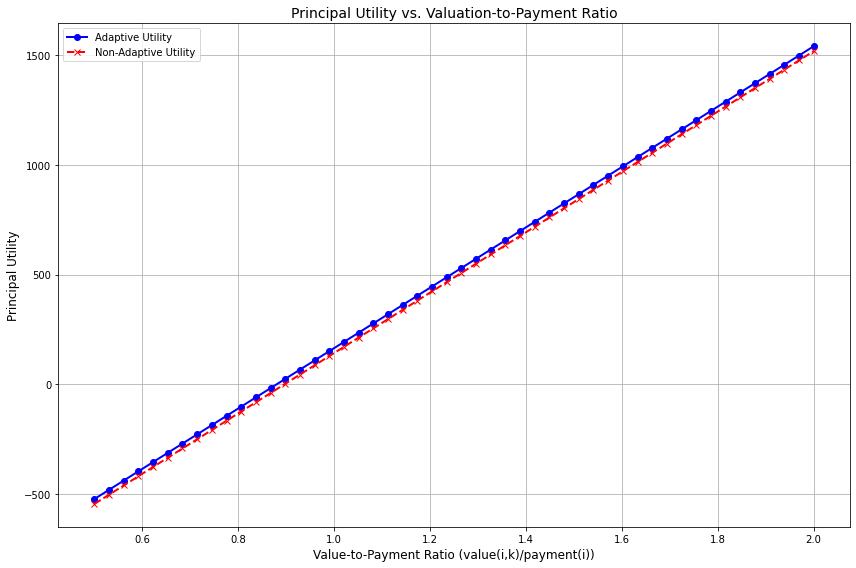

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize parameters explicitly provided by the user
def initialize_parameters(seed=7, num_agents=1000, m=3, penalty_margin=0.5):
    np.random.seed(seed)
    type_dist = np.random.dirichlet(np.random.uniform(1, 2, m))
    payments, penalties = generate_payments_and_penalties(type_dist, penalty_margin, m)
    return num_agents, m, type_dist, payments, penalties

# Explicit payment and penalty calculation
def generate_payments_and_penalties(type_dist, penalty_margin, m):
    payments = np.zeros(m)
    cumulative = 0
    for i in range(m):
        cumulative += type_dist[i]
        payments[i] = 1 + cumulative / 2
    penalties = payments + penalty_margin
    return payments, penalties

# Valuation explicitly dependent only on type i (modified by alpha ratio)
def valuation_function(i, k, payments, alpha):
    if k == i:
        return alpha * payments[i]
    elif k > i:
        return max(alpha * payments[i] - 0.2 * (k - i), 0.0)
    else:
        return max(alpha * payments[i] - 0.4 * (i - k), 0.0)

# Principal utility explicitly using provided valuation function
def principal_utility(type_dist, audit_vector, cost, equilibrium_strategy, num_agents, payments, penalties, alpha):
    utility = 0
    for idx in range(len(type_dist)):
        reported_type = equilibrium_strategy[idx]
        valuation = valuation_function(idx, reported_type, payments, alpha)
        utility += type_dist[idx] * (
            valuation
            - payments[reported_type]
            + audit_vector[reported_type] * (penalties[reported_type] - cost)
        )
    return utility * num_agents

# Determine equilibrium explicitly
def determine_equilibrium_strategy(payments, penalties, audit_vector, epsilon):
    u_hat = np.max(payments - audit_vector * penalties)
    A_hat = np.where(payments - audit_vector * penalties >= u_hat - epsilon)[0]
    equilibrium_strategy = np.zeros(len(payments), int)
    for idx in range(len(payments)):
        truthful_util = payments[idx]
        equilibrium_strategy[idx] = idx if truthful_util >= u_hat - epsilon else np.min(A_hat)
    return equilibrium_strategy

# Explicit search for optimal non-adaptive utility considering epsilon
def optimal_non_adaptive_policy(type_dist, payments, penalties, cost, m, num_agents, epsilon, alpha):
    best_utility = -np.inf
    optimal_audit_vector = np.zeros(m)
    for i in range(m - 1):
        for u in [payments[i] + epsilon, payments[i + 1] - epsilon]:
            audit_vector = np.zeros(m)
            for k in range(m):
                if k < i:
                    audit_vector[k] = 0
                else:
                    audit_vector[k] = np.clip((payments[k] - u) / penalties[k], 0, 1)
            eq_strategy = determine_equilibrium_strategy(payments, penalties, audit_vector, epsilon)
            utility = principal_utility(type_dist, audit_vector, cost, eq_strategy, num_agents, payments, penalties, alpha)
            if utility > best_utility:
                best_utility = utility
                optimal_audit_vector = audit_vector.copy()
    return best_utility, optimal_audit_vector

# Explicit search for optimal adaptive utility without epsilon
def optimal_adaptive_policy(type_dist, payments, penalties, cost, m, num_agents, alpha):
    epsilon = 0
    best_utility = -np.inf
    optimal_audit_vector = np.zeros(m)
    for i in range(m - 1):
        for u in [payments[i], payments[i + 1]]:
            audit_vector = np.zeros(m)
            for k in range(m):
                if k < i:
                    audit_vector[k] = 0
                else:
                    audit_vector[k] = np.clip((payments[k] - u) / penalties[k], 0, 1)
            eq_strategy = determine_equilibrium_strategy(payments, penalties, audit_vector, epsilon)
            utility = principal_utility(type_dist, audit_vector, cost, eq_strategy, num_agents, payments, penalties, alpha)
            if utility > best_utility:
                best_utility = utility
                optimal_audit_vector = audit_vector.copy()
    return best_utility, optimal_audit_vector

# Explicitly verify assumptions A1–A7
def verify_assumptions(payments, penalties, cost, type_dist, audit_vector, epsilon=None):
    A1 = np.all(cost <= penalties)
    A2 = np.all(np.diff(payments) / payments[:-1] >= np.diff(penalties) / penalties[:-1])
    A3 = np.all(np.diff(payments) >= 0)
    A4 = np.all(penalties >= payments)
    A5 = np.isclose(np.sum(type_dist), 1)
    min_payment_diff = np.min(np.diff(payments))
    if epsilon is not None:
        A6 = (0 < epsilon < 0.5 * min_payment_diff)
    else:
        A6 = True
    A7 = np.all((audit_vector >= 0) & (audit_vector <= 1))
    return A1, A2, A3, A4, A5, A6, A7

# Main simulation explicitly analyzing valuation-to-payment ratio effects
def simulate_valuation_to_payment_ratio(m=3, penalty_margin=0.5, epsilon=0.05, 
                                        alpha_values=np.linspace(0.5, 2.0, 50), cost=1.0):
    num_agents, m, type_dist, payments, penalties = initialize_parameters(m=m, penalty_margin=penalty_margin)
    adaptive_utils, non_adaptive_utils, valid_alphas = [], [], []

    for alpha in alpha_values:
        # Adaptive setting explicitly
        adaptive_util, adaptive_audit = optimal_adaptive_policy(type_dist, payments, penalties, cost, m, num_agents, alpha)
        adaptive_eq_strategy = determine_equilibrium_strategy(payments, penalties, adaptive_audit, epsilon=0)
        adaptive_checks = verify_assumptions(payments, penalties, cost, type_dist, adaptive_audit, epsilon=None)

        # Non-adaptive setting explicitly
        non_adaptive_util, non_adaptive_audit = optimal_non_adaptive_policy(type_dist, payments, penalties, cost, m, num_agents, epsilon, alpha)
        non_adaptive_eq_strategy = determine_equilibrium_strategy(payments, penalties, non_adaptive_audit, epsilon=epsilon)
        non_adaptive_checks = verify_assumptions(payments, penalties, cost, type_dist, non_adaptive_audit, epsilon=epsilon)

        # Explicit assumption validation
        if not all(adaptive_checks):
            print(f"Adaptive assumption violation at alpha={alpha:.3f}: {adaptive_checks}")
            continue
        if not all(non_adaptive_checks):
            print(f"Non-Adaptive assumption violation at alpha={alpha:.3f}: {non_adaptive_checks}")
            continue

        valid_alphas.append(alpha)
        adaptive_utils.append(adaptive_util)
        non_adaptive_utils.append(non_adaptive_util)

    if not valid_alphas:
        print("No valid scenarios found explicitly. Adjust parameters explicitly.")
        return

    # Explicit plotting of results
    plt.figure(figsize=(12, 8))
    plt.plot(valid_alphas, adaptive_utils, 'b-o', label='Adaptive Utility', linewidth=2)
    plt.plot(valid_alphas, non_adaptive_utils, 'r--x', label='Non-Adaptive Utility', linewidth=2)

    plt.xlabel('Value-to-Payment Ratio (value(i,k)/payment(i))', fontsize=12)
    plt.ylabel('Principal Utility', fontsize=12)
    plt.title('Principal Utility vs. Valuation-to-Payment Ratio', fontsize=14)
    plt.grid(True)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig('valuation_to_payment_ratio_effect.png', dpi=300)
    plt.show()

if __name__ == "__main__":
    simulate_valuation_to_payment_ratio()
